In [180]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [79]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [ ]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = 700
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

d_all = xgb.DMatrix(X)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=False, early_stopping_rounds=10)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

In [81]:
def split_into_five_equal_parts(X, y_binary, y_continuous, random_state=42):
    """
    Split data into 5 equal parts, maintaining alignment between binary and continuous outcomes
    
    Parameters:
    -----------
    X : features DataFrame
    y_binary : binary outcome (change/no change in LEDD)
    y_continuous : continuous outcome (normalized percentage change)
    random_state : for reproducibility
    
    Returns:
    --------
    Training, calibration, and test sets for both binary and continuous outcomes
    """
    # First split: 20% for test set, 80% remaining -> Test
    X_temp, X_test, y_binary_temp, y_binary_test, y_cont_temp, y_cont_test = train_test_split(
        X, y_binary, y_continuous, test_size=0.2, random_state=random_state
    )
    
    # Splits 75% of the 80%, which leaves one set with 20% and another with 60% -> Train
    X_train, X_temp2, y_binary_train, y_binary_temp2, y_cont_train, y_cont_temp2 = train_test_split(
        X_temp, y_binary_temp, y_cont_temp, test_size=0.75, random_state=random_state
    )
    
    # Splits 66% of the 60%, which leaves one set with 20% and another with 40% -> Calib1
    X_calib1, X_temp3, y_binary_calib1, y_binary_temp3, y_cont_calib1, y_cont_temp3 = train_test_split(
        X_temp2, y_binary_temp2, y_cont_temp2, test_size=0.666, random_state=random_state
    )

    # Splits 50% of the 40%, which leaves two sets with 20% each -> Calib2 and Calib3
    X_calib2, X_calib3, y_binary_calib2, y_binary_calib3, y_cont_calib2, y_cont_calib3 = train_test_split(
        X_temp3, y_binary_temp3, y_cont_temp3, test_size=0.5, random_state=random_state
    )
    
    return (
        X_train, X_calib1, X_calib2, X_calib3, X_test,
        y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
        y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test
    )

In [212]:
def conformal_prediction_zero_inflated(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(X, y_binary, y_continuous)
    
    # Train classification model on binary outcome
    classifier = xgb.XGBClassifier(**binary_params)
    # Fit classifier with binary outcome (change/no change in LEDD)
    classifier.fit(X_train, y_binary_train)
    # Get predicted probabilities for class one[:,] (change in LEDD) from the first calibration set
    # These probabilities will be used to calculate alpha_r
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Train regression model on non-zero continuous outcomes
    # Use mask to filter out patients with no change in LEDD or whose predicted probabily of change is minimal
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    # Fit regressor with continuous outcome (normalized percentage change)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    
    # print(f'First calibration dataset{probs_calib1, probs_calib1}')
    # Try different values of r to optimize intervals
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # X amount of data is below alpha_r
    for r in r_values:
        # Find quantiles for predicted probabilities
        alpha_r = np.quantile(probs_calib1, r)
        # print(f'alpha_r: {alpha_r}')

        # Second calibration set: Calculate beta_hat and accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1] # Predicted probabilities for the secnd calibration set
        pred_zeros = probs_calib2 <= alpha_r # Predicted probabilities less than or equal to alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0) # Accuracy of zero predictions (propotion of correct zero predictions) proportion of true zeros among predicted zerps
        # print(f'beta_hat: {beta_hat}')
        # Calculate final quantile for interval width
        # beta_hat * r coverage ww aleady achieved. 1-r is a fraction of the nonzero data
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        if final_quantile < 0 or final_quantile > 1:
            continue
            
            # A: Prob of true value being zero
            # B: Model predict this point as zero
        # Third calibration set: Calculate interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
            
        y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
        residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero) # True vs Predicted
        interval_width = np.quantile(residuals, final_quantile) # We choose the quantile of the predicted residuals
        all_interval_lengths.append((r, interval_width*(1-r), alpha_r)) # Average int_width = interval_width*(1 - r)
    
    # Choose best r value and corresponding width
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Make predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    test_pred = regressor.predict(X_test)
    
    # Create prediction intervals
    lower_bound = np.zeros_like(test_pred)
    upper_bound = np.zeros_like(test_pred)
    nonzero_mask = test_probs > best_alpha_r
    
    lower_bound[nonzero_mask] = test_pred[nonzero_mask] - best_width
    upper_bound[nonzero_mask] = test_pred[nonzero_mask] + best_width
    
    return lower_bound, upper_bound, y_cont_test

In [217]:
lower_bound, upper_bound, y_test = conformal_prediction_zero_inflated(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9  # Target coverage (90%)
)
# PLot new vs old
# Calculate and print coverage
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
interval_width = np.mean(upper_bound - lower_bound)
print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

Coverage: 0.785
Average interval width: 0.017


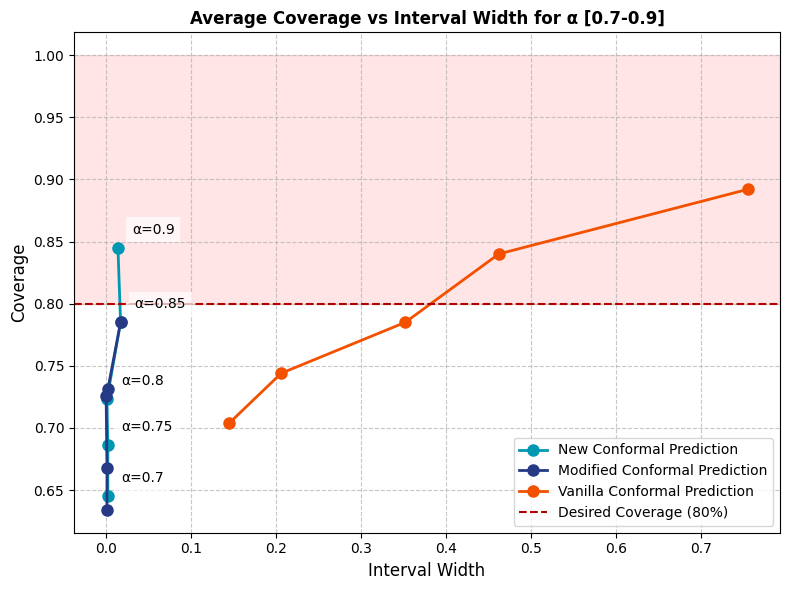

In [231]:
# Data for plotting
conformal_metrics_new = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.645, 0.686, 0.723, 0.785, 0.845],
    "interval_width": [0.002, 0.002, 0.001, 0.017, 0.0139]
}
conformal_metrics_modified = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.634, 0.668, 0.726, 0.731, 0.785],
    "interval_width": [0.001, 0.001, 0.000, 0.002, 0.017]
}
conformal_metrics_vanilla = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.704, 0.744, 0.785, 0.840, 0.892],
    "interval_width": [0.145, 0.206, 0.352, 0.462, 0.755]
}


plt.figure(figsize=(8, 6))

# Create scatter plot with connecting lines
plt.plot(conformal_metrics_new["interval_width"], conformal_metrics_new["coverage"],'-o', color='#0097B2', linewidth=2, markersize=8, label='New Conformal Prediction')
plt.plot(conformal_metrics_modified["interval_width"], conformal_metrics_modified["coverage"],'-o', color='#263985', linewidth=2, markersize=8, label='Modified Conformal Prediction')
plt.plot(conformal_metrics_vanilla["interval_width"], conformal_metrics_vanilla["coverage"],'-o', color='#F35000', linewidth=2, markersize=8, label='Vanilla Conformal Prediction')
# Add alpha labels to each point
for i, alpha in enumerate(conformal_metrics_new["alpha"]):
    plt.annotate(f'α={alpha}', (conformal_metrics_new["interval_width"][i], conformal_metrics_new["coverage"][i]), xytext=(10, 10), textcoords='offset points', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Add reference line
plt.axhline(y=0.8, linestyle='--', color='#B00000', label='Desired Coverage (80%)')

# Customize plot
plt.title('Average Coverage vs Interval Width for α [0.7-0.9]', fontsize=12, weight='bold')
plt.xlabel('Interval Width', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add shaded region for desired coverage
plt.axhspan(0.8, 1.0, alpha=0.1, color='red', label='Target Coverage Zone')
plt.tight_layout()
# plt.savefig('coverage_vd_intwidth_new_conformal.svg', transparent=True)
plt.show()

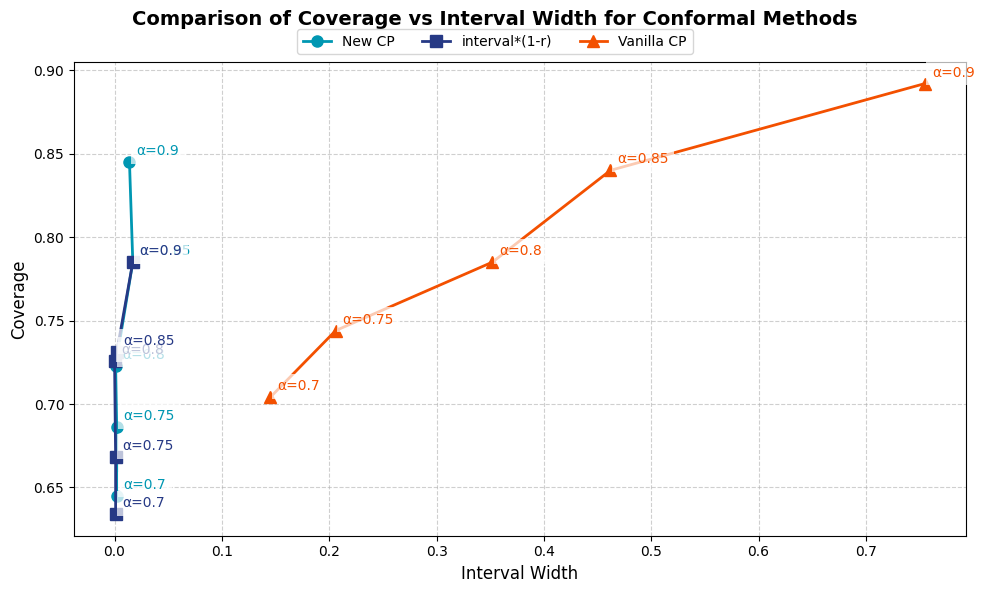

In [276]:
import matplotlib.pyplot as plt

# Data for plotting
conformal_metrics_new = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.645, 0.686, 0.723, 0.785, 0.845],
    "interval_width": [0.002, 0.002, 0.001, 0.017, 0.0139]
}
conformal_metrics_modified = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.634, 0.668, 0.726, 0.731, 0.785],
    "interval_width": [0.001, 0.001, 0.000, 0.002, 0.017]
}
conformal_metrics_vanilla = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.704, 0.744, 0.785, 0.840, 0.892],
    "interval_width": [0.145, 0.206, 0.352, 0.462, 0.755]
}
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Comparison of Coverage vs Interval Width for Conformal Methods', fontsize=14, weight='bold')

# Plotting each method
methods = {
    "New CP": ("#0097B2", "o", conformal_metrics_new),
    "interval*(1-r)": ("#263985", "s", conformal_metrics_modified),
    "Vanilla CP": ("#F35000", "^", conformal_metrics_vanilla),
}

for label, (color, marker, data) in methods.items():
    ax.plot(data["interval_width"], data["coverage"], 
             marker=marker, color=color, linewidth=2, markersize=8, label=label)
    for i, alpha in enumerate(data["alpha"]):
        ax.annotate(f'α={alpha}',(data["interval_width"][i], data["coverage"][i]), xytext=(5, 5), textcoords='offset points', fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), color=color)

# Add reference lines and shaded regions
# ax.axhline(y=0.8, linestyle='--', color='#B00000', linewidth=1.5, label='Target Coverage (80%)')
# ax.axhspan(0.8, 1.0, alpha=0.1, color='red', label='Target Coverage Zone')

# Customize plot
ax.set_xlabel('Interval Width', fontsize=12)
ax.set_ylabel('Coverage', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 0.96), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.975])
# plt.savefig('conformal_comparison.svg', transparent=True, bbox_inches='tight')
plt.show()

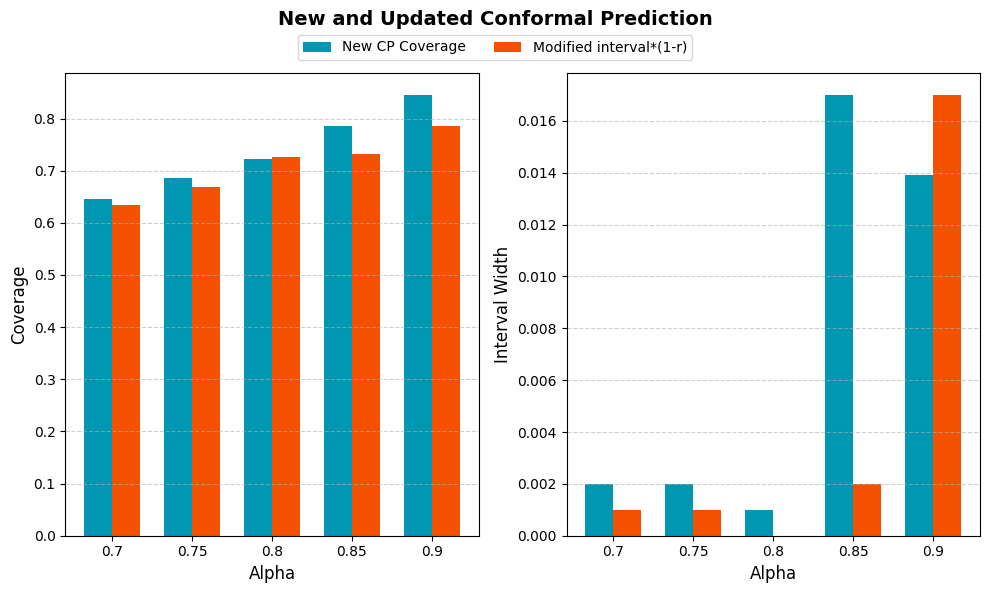

In [306]:
width = 0.35  # Bar width
x = np.arange(len(conformal_metrics_new["alpha"]))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 6))
ax1.bar(x - width/2, conformal_metrics_new["coverage"], width, label='New CP Coverage', color='#0097B2')
ax1.bar(x + width/2, conformal_metrics_modified["coverage"], width, label='Modified interval*(1-r)', color='#F35000')
ax1.set_xticks(x)
ax1.set_xticklabels(conformal_metrics_new["alpha"])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.bar(x - width/2, conformal_metrics_new["interval_width"], width, color='#0097B2')
ax2.bar(x + width/2, conformal_metrics_modified["interval_width"], width, color='#F35000')
ax2.set_xticks(x)
ax2.set_xticklabels(conformal_metrics_new["alpha"])
ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9]) 
fig.suptitle('New and Updated Conformal Prediction', fontsize=14, weight='bold')
plt.show()

In [89]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction using MAPIE for regression intervals.
    First stage: XGBoost classifier to predict zero/non-zero
    Second stage: MAPIE with XGBoost regressor for prediction intervals
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # First stage: Classification model
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Try different r values
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Initialize MAPIE with XGBoost regressor
    regressor = xgb.XGBRegressor(**regression_params_short)
    mapie = MapieRegressor(
        estimator=regressor,
        method="plus",  # Jack-knife+ method
        cv="prefit",
        random_state=42
    )
    
    # Fit regressor on non-zero training data
    mask_nonzero = y_binary_train == 1
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    for r in r_values:
        # First calibration: threshold for zero/non-zero
        alpha_r = np.quantile(probs_calib1, r)
        
        # Second calibration: accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        # Calculate final quantile
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        if final_quantile < 0 or final_quantile > 1:
            continue
            
        # Third calibration: Use MAPIE for interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
        
        # Fit MAPIE on non-zero calibration data
        X_calib3_nonzero = X_calib3[nonzero_mask]
        y_calib3_nonzero = y_cont_calib3[nonzero_mask]
        
        # Get MAPIE prediction intervals
        mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
        _, y_pis = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
        
        # Calculate interval width as mean of MAPIE intervals
        interval_width = np.mean(y_pis[:, 1, 0] - y_pis[:, 0, 0])
        all_interval_lengths.append((r, interval_width, alpha_r))
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found. Try adjusting r_values or alpha_tilda.")
    
    # Choose best r value
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Final predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    nonzero_mask_test = test_probs > best_alpha_r
    
    # Initialize bounds
    lower_bound = np.zeros(len(X_test))
    upper_bound = np.zeros(len(X_test))
    
    if any(nonzero_mask_test):
        # Get MAPIE predictions for non-zero cases
        _, y_pis_test = mapie.predict(X_test[nonzero_mask_test], alpha=0.8)
        lower_bound[nonzero_mask_test] = y_pis_test[:, 0, 0]
        upper_bound[nonzero_mask_test] = y_pis_test[:, 1, 0]
    
    return lower_bound, upper_bound, y_cont_test

# Usage
lower_bound_mapie, upper_bound_mapie, y_test_mapie = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

# Calculate coverage and interval width
coverage_mapie = np.mean((y_test_mapie >= lower_bound_mapie) & (y_test_mapie <= upper_bound_mapie))
interval_width_mapie = np.mean(upper_bound_mapie - lower_bound_mapie)
print(f"MAPIE Coverage: {coverage_mapie:.3f}")
print(f"MAPIE Average interval width: {interval_width_mapie:.3f}")

MAPIE Coverage: 0.735
MAPIE Average interval width: 0.003


In [87]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction using MAPIE for regression intervals.
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # First stage: Classification model
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Try different r values
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Initialize MAPIE with XGBoost regressor
    regressor = xgb.XGBRegressor(**regression_params_short)
    
    # Fit regressor on non-zero training data
    mask_nonzero = y_binary_train == 1
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Initialize MAPIE with the fitted regressor
    mapie = MapieRegressor(
        estimator=regressor,
        method="plus",
        cv="prefit",
        random_state=42
    )
    
    for r in r_values:
        # First calibration: threshold for zero/non-zero
        alpha_r = np.quantile(probs_calib1, r)
        
        # Second calibration: accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        # Calculate final quantile and ensure it's in [0,1]
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        final_quantile = np.clip(final_quantile, 0.01, 0.99)  # Clip to valid range
        
        # Third calibration: Use MAPIE for interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
        
        # Fit MAPIE on non-zero calibration data
        X_calib3_nonzero = X_calib3[nonzero_mask]
        y_calib3_nonzero = y_cont_calib3[nonzero_mask]
        
        try:
            # Get MAPIE prediction intervals
            mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
            _, y_pis = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
            
            # Calculate interval width as mean of MAPIE intervals
            interval_width = np.mean(y_pis[:, 1, 0] - y_pis[:, 0, 0])
            all_interval_lengths.append((r, interval_width, alpha_r))
        except Exception as e:
            print(f"Skipping r={r} due to error: {e}")
            continue
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found. Try adjusting r_values or alpha_tilda.")
    
    # Choose best r value
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Final predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    nonzero_mask_test = test_probs > best_alpha_r
    
    # Initialize bounds
    lower_bound = np.zeros(len(X_test))
    upper_bound = np.zeros(len(X_test))
    
    if any(nonzero_mask_test):
        # Get MAPIE predictions for non-zero cases
        _, y_pis_test = mapie.predict(X_test[nonzero_mask_test], alpha=0.9)  # Use fixed alpha for final prediction
        lower_bound[nonzero_mask_test] = y_pis_test[:, 0, 0]
        upper_bound[nonzero_mask_test] = y_pis_test[:, 1, 0]
    
    return lower_bound, upper_bound, y_cont_test

In [88]:
lower_bound_mapie, upper_bound_mapie, y_test_mapie = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

# Calculate coverage and interval width
coverage_mapie = np.mean((y_test_mapie >= lower_bound_mapie) & (y_test_mapie <= upper_bound_mapie))
interval_width_mapie = np.mean(upper_bound_mapie - lower_bound_mapie)
print(f"MAPIE Coverage: {coverage_mapie:.3f}")
print(f"MAPIE Average interval width: {interval_width_mapie:.3f}")

MAPIE Coverage: 0.737
MAPIE Average interval width: 0.001


In [114]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnnotationBbox, TextArea

round_to = 2

def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    # axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    # axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    # axs.errorbar(
    #     y_test_sorted_[warnings],
    #     y_pred_sorted_[warnings],
    #     yerr=np.abs(error[warnings]),
    #     capsize=5, marker="x", elinewidth=2, linewidth=0, color="red",
    #     label="Outside prediction interval"
    #     )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True Percent Change of LEDD")
    axs.set_ylabel("Prediction of Percent Change of LEDD")
    lims = [
    np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
    np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
]
    # lims = [-1,1]
    ab = AnnotationBbox(
    TextArea(
        f"Coverage: {np.round(coverage, round_to)}\n"
        + f"Interval width: {np.round(width, round_to)}"
    ),
    xy=(lims[0] * 0.9, lims[1] * 0.9),  # Position annotation more relative to axis limits
    xycoords='data',
    boxcoords="offset points",
    frameon=True
    )
    axs.grid(True)
    axs.set_xlim(lims)
    axs.set_ylim(lims)
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(



Strategy: naive
Coverage: 0.734
Average interval width: 0.000

Strategy: cv_plus
Coverage: 0.732
Average interval width: 0.011

Strategy: jackknife_plus_ab
Coverage: 0.729
Average interval width: 0.004


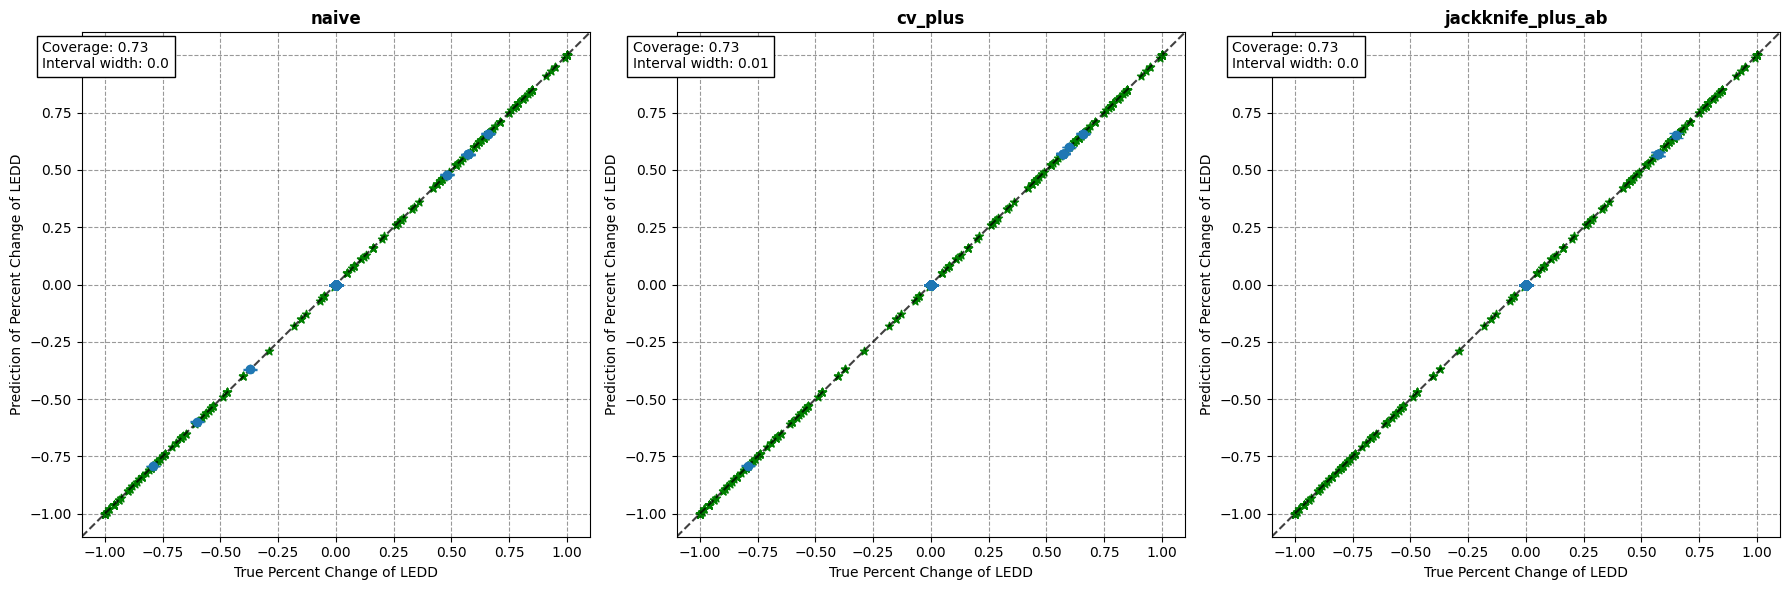

In [115]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction with multiple MAPIE strategies
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # Define MAPIE strategies like in your original code
    STRATEGIES = {
        "naive": {"method": "naive"},
        "cv_plus": {"method": "plus", "cv": 10},
        "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    }
    
    # Initialize dictionaries to store results
    y_pred, y_pis = {}, {}
    y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
    coverage, width = {}, {}
    
    # First stage: Classification model (common for all strategies)
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # For each MAPIE strategy
    for strategy, params in STRATEGIES.items():
        # Initialize regressor
        regressor = xgb.XGBRegressor(**regression_params_short)
        
        # Initialize MAPIE with current strategy
        mapie = MapieRegressor(
            estimator=regressor,
            random_state=42,
            **params
        )
        
        # Try different r values
        r_values = np.arange(0.1, 0.95, 0.05)
        all_interval_lengths = []
        
        for r in r_values:
            # First calibration: threshold for zero/non-zero
            alpha_r = np.quantile(probs_calib1, r)
            
            # Second calibration: accuracy of zero predictions
            probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
            pred_zeros = probs_calib2 <= alpha_r
            beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
            
            # Calculate final quantile and ensure it's in [0,1]
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            final_quantile = np.clip(final_quantile, 0.01, 0.99)
            
            # Third calibration: Use MAPIE for interval width
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            
            if not any(nonzero_mask):
                continue
            
            try:
                # Fit MAPIE on non-zero data
                X_calib3_nonzero = X_calib3[nonzero_mask]
                y_calib3_nonzero = y_cont_calib3[nonzero_mask]
                
                mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
                _, y_pis_calib = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
                
                # Calculate interval width
                interval_width = np.mean(y_pis_calib[:, 1, 0] - y_pis_calib[:, 0, 0])
                all_interval_lengths.append((r, interval_width, alpha_r, mapie))
                
            except Exception as e:
                print(f"Skipping {strategy} with r={r} due to error: {e}")
                continue
        
        if not all_interval_lengths:
            print(f"No valid intervals found for strategy {strategy}")
            continue
        
        # Choose best r value and corresponding MAPIE model
        best_r, best_width, best_alpha_r, best_mapie = min(all_interval_lengths, key=lambda x: x[1])
        
        # Final predictions on test set
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask_test = test_probs > best_alpha_r
        
        # Initialize bounds
        lower_bound[strategy] = np.zeros(len(X_test))
        upper_bound[strategy] = np.zeros(len(X_test))
        
        if any(nonzero_mask_test):
            _, y_pis_test = best_mapie.predict(X_test[nonzero_mask_test], alpha=alpha_tilda)
            lower_bound[strategy][nonzero_mask_test] = y_pis_test[:, 0, 0]
            upper_bound[strategy][nonzero_mask_test] = y_pis_test[:, 1, 0]
        
        # Calculate coverage and width using MAPIE metrics
        coverage[strategy] = regression_coverage_score(
            y_cont_test,
            lower_bound[strategy],
            upper_bound[strategy]
        )
        width[strategy] = regression_mean_width_score(
            lower_bound[strategy],
            upper_bound[strategy]
        )
    
    return lower_bound, upper_bound, y_cont_test, coverage, width

# Run the analysis
results = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

lower_bound, upper_bound, y_test, coverage, width = results

# Print results for each strategy
for strategy in coverage.keys():
    print(f"\nStrategy: {strategy}")
    print(f"Coverage: {coverage[strategy]:.3f}")
    print(f"Average interval width: {width[strategy]:.3f}")

# Visualization similar to your original code
rng = np.random.default_rng(21)
perc_obs_plot = 0.90
num_plots = rng.choice(len(y_test), int(perc_obs_plot*len(y_test)), replace=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
coords = axs.ravel()

for strategy, coord in zip(lower_bound.keys(), coords):
    plot_prediction_intervals(
        strategy, coord, y_test, (lower_bound[strategy] + upper_bound[strategy])/2,
        lower_bound[strategy], upper_bound[strategy],
        coverage[strategy], width[strategy],
        num_plots
    )
    coord.grid(True, linestyle='--', alpha=0.4, linewidth=0.8, color='black')

plt.tight_layout()
plt.show()

Coverage: 0.892
Average interval width: 0.755


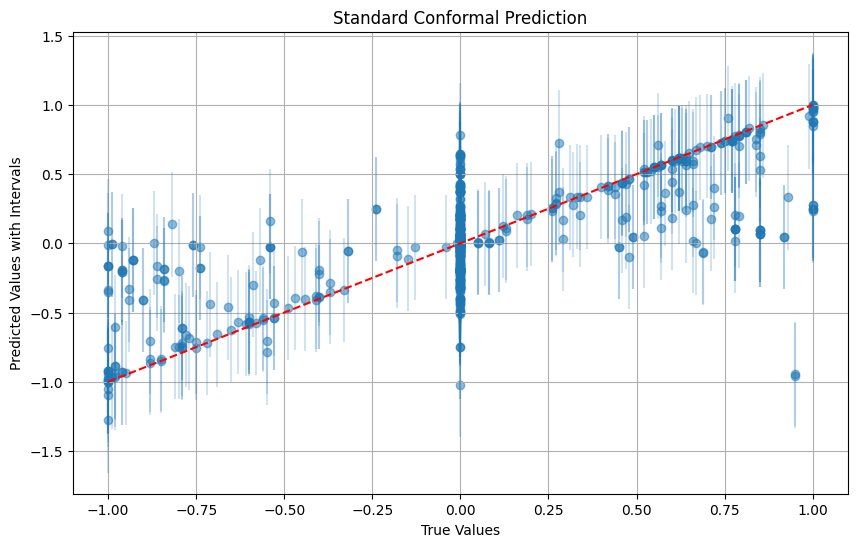

In [224]:
def standard_conformal_prediction(X_train, y_train, X_calib, y_calib, X_test, alpha=0.9):
    """
    Basic conformal prediction implementation.
    
    Parameters:
    -----------
    X_train : Training features
    y_train : Training target
    X_calib : Calibration features
    y_calib : Calibration target
    X_test : Test features
    alpha : Target coverage level (default 0.9 for 90% coverage)
    
    Returns:
    --------
    lower_bound, upper_bound : Prediction intervals for test set
    """
    # 1. Train the model on training data
    model = xgb.XGBRegressor(**regression_params_short)
    model.fit(X_train, y_train)
    
    # 2. Calculate nonconformity scores on calibration set
    calib_preds = model.predict(X_calib)
    nonconformity_scores = np.abs(y_calib - calib_preds)
    
    # 3. Find the quantile corresponding to desired coverage
    quantile = np.quantile(nonconformity_scores, alpha)
    
    # 4. Make predictions on test set
    test_preds = model.predict(X_test)
    
    # 5. Create prediction intervals
    lower_bound = test_preds - quantile
    upper_bound = test_preds + quantile
    
    return lower_bound, upper_bound

# Usage example:
# First split data into train, calibration, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, normalized_pctg_change, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Get prediction intervals
lower, upper = standard_conformal_prediction(
    X_train, y_train,
    X_calib, y_calib,
    X_test,
    alpha=0.9
)

# Calculate coverage
coverage = np.mean((y_test >= lower) & (y_test <= upper))
interval_width = np.mean(upper - lower)

print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, (upper + lower)/2, alpha=0.5)
plt.errorbar(y_test, (upper + lower)/2, 
            yerr=(upper - lower)/2, 
            fmt='none', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         '--', color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values with Intervals')
plt.title('Standard Conformal Prediction')
plt.grid(True)
plt.show()